In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# nltk.download('stopwords')


In [8]:
df = pd.read_csv("SC_Vuln_8label.csv")
print(df.head())
print(df.isnull().sum()) #no missing values

   Unnamed: 0   filename                                               code  \
0           0  33790.sol  pragma solidity ^0.4.4;\r\n\r\ncontract Token ...   
1           1  31454.sol  pragma solidity ^0.4.4;\r\n\r\ncontract Token ...   
2           2  40744.sol  contract SendBalance {\r\n mapping (address =>...   
3           3  39290.sol  /**\r\n * Originally from https://github.com/C...   
4           4  39358.sol  pragma solidity ^0.4.4;\r\n\r\nlibrary ArrayLi...   

                        label  label_encoded  
0  ./Dataset/reentrancy (RE)/              5  
1  ./Dataset/reentrancy (RE)/              5  
2  ./Dataset/reentrancy (RE)/              5  
3  ./Dataset/reentrancy (RE)/              5  
4  ./Dataset/reentrancy (RE)/              5  
Unnamed: 0       0
filename         0
code             0
label            0
label_encoded    0
dtype: int64


In [9]:
value_counts = df['label_encoded'].value_counts()
print(value_counts)

label_encoded
5    1218
7    1199
4     590
0     406
3     366
6     312
1      97
2      97
Name: count, dtype: int64


In [10]:
print(df['code'][0])

pragma solidity ^0.4.4;

contract Token {

    /// @return total amount of tokens
    function totalSupply(uint256) constant returns (uint256 supply) {}

    /// @param _owner The address from which the balance will be retrieved
    /// @return The balance
    function balanceOf(address _owner) constant returns (uint256 balance) {}

    /// @notice send `_value` token to `_to` from `msg.sender`
    /// @param _to The address of the recipient
    /// @param _value The amount of token to be transferred
    /// @return Whether the transfer was successful or not
    function transfer(address _to, uint256 _value) returns (bool success) {}

    /// @notice send `_value` token to `_to` from `_from` on the condition it is approved by `_from`
    /// @param _from The address of the sender
    /// @param _to The address of the recipient
    /// @param _value The amount of token to be transferred
    /// @return Whether the transfer was successful or not
    function transferFrom(address _from, a

In [11]:
import pandas as pd

# 读取原始数据
df = pd.read_csv("SC_Vuln_8label.csv",index_col=0)

# 8 个漏洞类别
labels = [
    "./Dataset/block number dependency (BN)",
    "./Dataset/dangerous delegatecall (DE)/",
    "./Dataset/ether frozen (EF)",
    "./Dataset/ether strict equality (SE)",
    "./Dataset/integer overflow (OF)/",
    "./Dataset/reentrancy (RE)/",
    "./Dataset/timestamp dependency (TP)/",
    "./Dataset/unchecked external call (UC)"
]

# 创建 8 个 label 列，默认全是 0
for label in labels:
    df[label] = 0

# 遍历数据，如果 `filename` 存在某个 `label`，就把对应列设为 1
for index, row in df.iterrows():
    if row["label"] in labels:
        df.at[index, row["label"]] = 1  # 设为 1

# 去掉 `label` 和 `label_encoded`，因为已经用 0/1 代替
df = df.drop(columns=["label", "label_encoded"])

# 按 `filename` 和 `code` 聚合数据，保证 `filename` 只出现一次，漏洞列合并成 0/1
df = df.groupby(["filename", "code"], as_index=False).max()

# 保存结果

# df.head(200).to_csv("SC_Vuln_8label_Processed.csv", index=False)

# print("Saved processed dataset as 'SC_Vuln_8label_Processed.csv'.")


📌 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   filename                                200 non-null    object
 1   code                                    200 non-null    object
 2   ./Dataset/block number dependency (BN)  200 non-null    int64 
 3   ./Dataset/dangerous delegatecall (DE)/  200 non-null    int64 
 4   ./Dataset/ether frozen (EF)             200 non-null    int64 
 5   ./Dataset/ether strict equality (SE)    200 non-null    int64 
 6   ./Dataset/integer overflow (OF)/        200 non-null    int64 
 7   ./Dataset/reentrancy (RE)/              200 non-null    int64 
 8   ./Dataset/timestamp dependency (TP)/    200 non-null    int64 
 9   ./Dataset/unchecked external call (UC)  200 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 15.8+ KB
None

🔹 

C:\Users\FLZ\AppData\Local\Temp\ipykernel_41272\1811738443.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


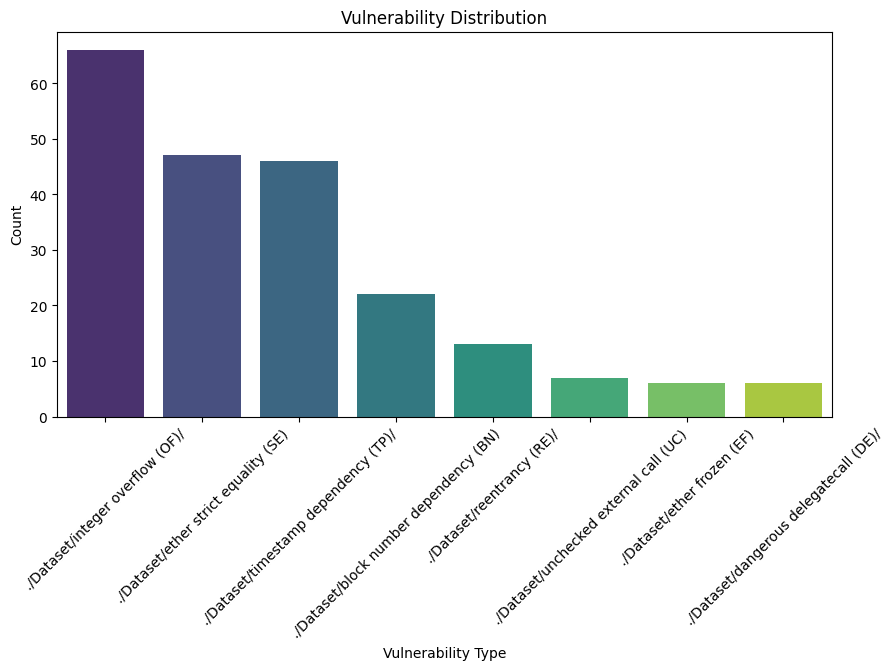

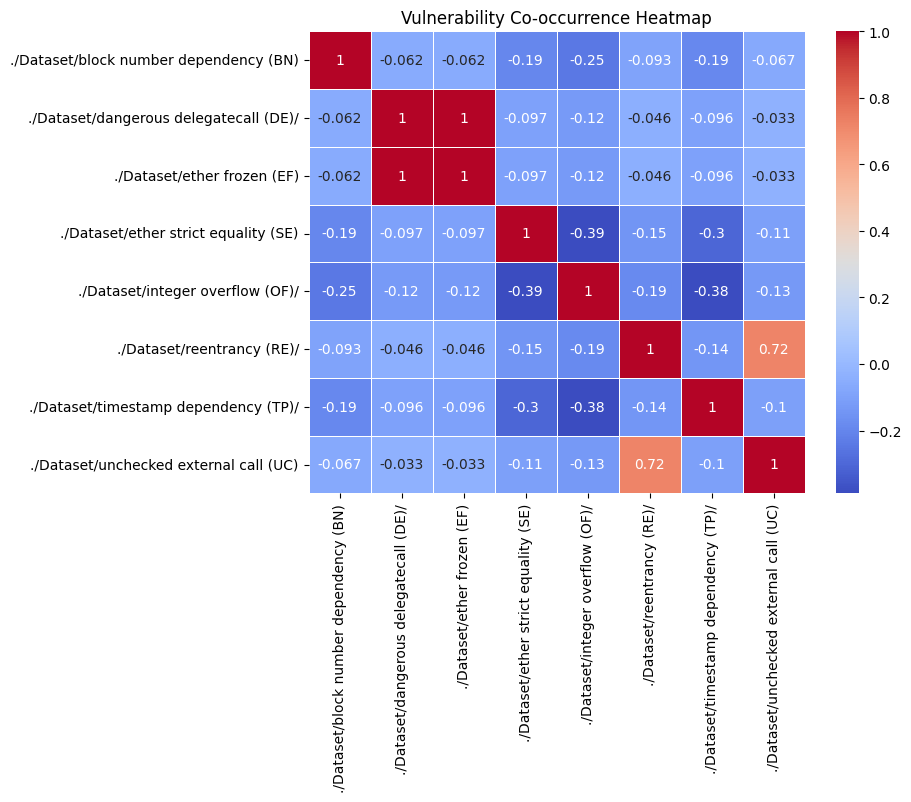

In [18]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv("SC_Vuln_8label_Processed.csv")

### === 1️⃣ Basic Dataset Information === ###
print("📌 Dataset Overview:")
print(df.info())   # Data types & missing values
print("\n🔹 Missing Value Statistics:\n", df.isnull().sum())
print("\n🔹 Total Rows in Dataset:", df.shape[0])

# Check if filenames are unique
print("\n🔹 Unique Filenames:", df["filename"].nunique())

# Count label (vulnerability) distribution
label_cols = [
    "./Dataset/block number dependency (BN)",
    "./Dataset/dangerous delegatecall (DE)/",
    "./Dataset/ether frozen (EF)",
    "./Dataset/ether strict equality (SE)",
    "./Dataset/integer overflow (OF)/",
    "./Dataset/reentrancy (RE)/",
    "./Dataset/timestamp dependency (TP)/",
    "./Dataset/unchecked external call (UC)"
]
label_counts = df[label_cols].sum().sort_values(ascending=False)
print("\n🔹 Vulnerability Label Distribution:\n", label_counts)

### === 2️⃣ Label Distribution Visualization === ###
plt.figure(figsize=(10,5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Vulnerability Type")
plt.ylabel("Count")
plt.title("Vulnerability Distribution")
plt.show()

### === 3️⃣ Co-occurrence Analysis (Heatmap) === ###
plt.figure(figsize=(8,6))
sns.heatmap(df[label_cols].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Vulnerability Co-occurrence Heatmap")
plt.show()


In [13]:
# solidity_stopwords = [
#     "pragma", "interface", "contract", "function", "event", "modifier", "library", "using",
#     "string", "uint8", "uint256", "address", "mapping", "bool", "require", "return", "memory",
#     "storage", "public", "internal", "view", "constant", "constructor",
#     "_owner", "_balances", "_allowances", "_founder", "_marketing", "_who", "_burntAmount",
#     "_from", "_to", "_value", "_timestamp", "_bool", "msg.sender", "totalSupply",
#     "balanceOf", "transfer", "allowance", "approve", "transferFrom", "add", "sub", "mul", "div",
#     "mod", "changeFounder", "setMinter", "setFurnace", "freezeAccount", "solidity", "bytes32"
# ]

def clean_code(code):
    # Remove comments (single-line and multi-line)
    code = re.sub(r'\/\/.*', '', code)
    code = re.sub(r'\/\*[\s\S]*?\*\/', '', code)
    code = re.sub(r"pragma solidity[^;]+;", "", code)
    code = re.sub(r"import [^;]+;", "", code)
    code = re.sub(r"\s+", " ", code).strip()

    string_literals = re.findall(r'"[^"]*"|\'[^\']*\'', code)
    string_map = {s: f'__STRING{idx}__' for idx, s in enumerate(string_literals)}
    for string, placeholder in string_map.items():
        code = code.replace(string, placeholder)
    
    return code
    
# def clean_code(solidity_code):
#     cleaned_code = re.sub(r'//.*?$', '', solidity_code, flags=re.MULTILINE)
#     cleaned_code = re.sub(r'/\*.*?\*/', '', cleaned_code, flags=re.DOTALL)
#     cleaned_code = re.sub(r'[^a-zA-Z0-9\s+=\-*&|/<>!(){};.,]', '', cleaned_code)
#     cleaned_code = '\n'.join(line.strip().lower() for line in cleaned_code.splitlines() if line.strip())

#     stop_words = set(stopwords.words('english'))
#     tokens = [word for word in cleaned_code.split() if word not in stop_words]
#     tokens = [token for token in tokens if token not in solidity_stopwords]

#     return tokens


df['clean_code'] = df['code'].apply(clean_code)
print(df['clean_code'])


0      contract BREBuy { struct ContractParam { uint3...
1      contract Token{ uint256 public totalSupply; fu...
2      library SafeMath { function mul(uint256 a, uin...
3      library SafeMath { function mul(uint256 a, uin...
4      contract MultiSigWallet { uint constant public...
                             ...                        
195    contract ERC20Basic { uint256 public totalSupp...
196    pragma experimental __STRING0__; contract Owne...
197    contract owned { address public owner; address...
198    interface tokenRecipient { function receiveApp...
199    interface tokenRecipient { function receiveApp...
Name: clean_code, Length: 200, dtype: object


In [14]:
#Tokenization helps extract important elements from the code
solidity_token_pattern = r"""
    [A-Za-z_][A-Za-z_0-9]*      
    |\d+\.\d+|\d+               
    |0x[0-9a-fA-F]+             
    |\d+e[+-]?\d+              
    |==|!=|>=|<=|\+=|-=|\*=|/=  
    |=>|=<|>>|<<|\+\+|--        
    |&&|\|\||!                  
    |[^\w\s]                    
"""

tokenizer = RegexpTokenizer(solidity_token_pattern, flags=re.VERBOSE)

df['tokens'] = df['clean_code'].apply(tokenizer.tokenize)
print(df['tokens'][0])

['contract', 'BREBuy', '{', 'struct', 'ContractParam', '{', 'uint32', 'totalSize', ';', 'uint256', 'singlePrice', ';', 'uint8', 'pumpRate', ';', 'bool', 'hasChange', ';', '}', 'address', 'owner', '=', '0', 'x0', ';', 'uint32', 'gameIndex', '=', '0', ';', 'uint256', 'totalPrice', '=', '0', ';', 'bool', 'isLock', '=', 'false', ';', 'ContractParam', 'public', 'setConfig', ';', 'ContractParam', 'public', 'curConfig', ';', 'address', '[', ']', 'public', 'addressArray', '=', 'new', 'address', '[', ']', '(', '0', ')', ';', 'event', 'openLockEvent', '(', ')', ';', 'event', 'addPlayerEvent', '(', 'uint32', 'gameIndex', ',', 'address', 'player', ')', ';', 'event', 'gameOverEvent', '(', 'uint32', 'gameIndex', ',', 'uint32', 'totalSize', ',', 'uint256', 'singlePrice', ',', 'uint8', 'pumpRate', ',', 'address', 'winAddr', ',', 'uint', 'overTime', ')', ';', 'event', 'stopGameEvent', '(', 'uint', 'totalBalace', ',', 'uint', 'totalSize', ',', 'uint', 'price', ')', ';', 'constructor', '(', 'uint32', '_t

In [15]:
#Feature Extraction to numerical features for TF-ID, feature matri
df['token_string'] = df['tokens'].apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer(max_features=1000) 
X_tfidf = vectorizer.fit_transform(df['token_string'])
print(X_tfidf[0])


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 65 stored elements and shape (1, 1000)>
  Coords	Values
  (0, 323)	0.005772037069074856
  (0, 844)	0.012560936927464733
  (0, 924)	0.18960358302025174
  (0, 923)	0.05025685664988344
  (0, 927)	0.03279678355551982
  (0, 278)	0.02973480334876582
  (0, 202)	0.07503648189797313
  (0, 664)	0.03508557473773877
  (0, 985)	0.011943489888052114
  (0, 415)	0.04121544959213452
  (0, 715)	0.052207428092041104
  (0, 809)	0.4533485371307443
  (0, 335)	0.6476407673296347
  (0, 203)	0.48573057549722604
  (0, 616)	0.01569870543649802
  (0, 407)	0.023787842679012655
  (0, 685)	0.021577926815430738
  (0, 919)	0.11458277425044103
  (0, 708)	0.08815974516492606
  (0, 322)	0.011089689413987476
  (0, 607)	0.046870690037305485
  (0, 808)	0.035153017527979113
  (0, 426)	0.09752118370179312
  (0, 603)	0.013822406077938658
  (0, 651)	0.03888846051299907
  :	:
  (0, 376)	0.03461568814472955
  (0, 553)	0.09485599970787051
  (0, 856)	0.015234694857622064

In [19]:
# encoder = LabelEncoder()
# df['label_encoded'] = encoder.fit_transform(df['label'])
# print(df['label_encoded'])



# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label_encoded'], test_size=0.2, random_state=42, stratify=df['label_encoded'])
# print(y_train.value_counts())
# print(y_test.value_counts())